##  Peers Visualization
#  The dataset named "NBA Player Statistics".
#  The dataset was provided by data.world
# we can obtain the data from https://www.basketball-reference.com/ and https://colab.research.google.com/drive/1fb4y802jp9b7DE-aEq5aSyQAIhmOqzPF?usp=sharing
# the dataset is available for public.
# The dataset file size is approximately 2.1 MB.
# The dataset contains 14,573 items (rows).


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load the CSV file into a DataFrame
nba_data = pd.read_csv("NBA_Player_Stats_2.csv")

In [15]:
# Filter the desired columns
filtered_nba_data = nba_data[["Rk", "Player", "Pos", "Age", "Tm", "G", "TRB", "AST", "STL", "BLK", "PTS", "Season", "MVP"]]
# Filter out rows where the Season is before "2008-09"
filtered_nba_data = filtered_nba_data[filtered_nba_data["Season"] > "2008-09"]
# Modify the "Season" column to keep only the last two characters
filtered_nba_data["Season"] = filtered_nba_data["Season"].str[-2:]
# Drop the "Tm" column
filtered_nba_data = filtered_nba_data.drop(columns=["Tm"])
# Group by Player and Season and calculate the weighted stats
grouped = filtered_nba_data.groupby(['Player', 'Season'])

In [16]:
# Calculate the weighted values for the specified columns based on the number of games played
weighted_stats = filtered_nba_data.groupby(['Player', 'Season']).apply(
    lambda x: pd.Series({
        'TRB': (x['TRB'] * x['G']).sum() / x['G'].sum(),
        'AST': (x['AST'] * x['G']).sum() / x['G'].sum(),
        'STL': (x['STL'] * x['G']).sum() / x['G'].sum(),
        'BLK': (x['BLK'] * x['G']).sum() / x['G'].sum(),
        'PTS': (x['PTS'] * x['G']).sum() / x['G'].sum(),
        'G': x['G'].sum(),
        'Pos': x['Pos'].mode()[0],  # Mode will help in selecting the most frequent position for the player
        'Age': x['Age'].mean(),  # Taking average age in case there are multiple entries
        'MVP': x['MVP'].max()  # Max will help in capturing if the player was an MVP in any of the rows
    })
).reset_index()

# Merge with original dataframe to get the 'Rk' column
merged_data = pd.merge(filtered_nba_data[['Player', 'Season', 'Rk']], weighted_stats, on=['Player', 'Season'], how='right')

# Remove duplicates
unique_data = merged_data.drop_duplicates(subset=['Player', 'Season']).reset_index(drop=True)



In [17]:
# Sort the dataframe by the "Season" column in ascending order
sorted_data = unique_data.sort_values(by="Season", ascending=True).reset_index(drop=True)
# Round the specified columns to two decimal places
cols_to_round = ["TRB", "AST", "STL", "BLK", "PTS"]
sorted_data[cols_to_round] = sorted_data[cols_to_round].round(2)
# Define the weights
weights = {
    "PTS": 1.5,
    "TRB": 2,
    "AST": 2,
    "STL": 3,
    "BLK": 3
}

# Calculate the Player Score for each row
sorted_data["Player Score"] = (
    sorted_data["PTS"] * weights["PTS"] +
    sorted_data["TRB"] * weights["TRB"] +
    sorted_data["AST"] * weights["AST"] +
    sorted_data["STL"] * weights["STL"] +
    sorted_data["BLK"] * weights["BLK"]
)

# Determine the best player for each season
best_players = sorted_data.loc[sorted_data.groupby("Season")["Player Score"].idxmax()][["Season", "Player", "Player Score", "TRB", "AST", "STL", "BLK", "PTS"]]

# Best Players Stats Radar Chart from 2020 to 2022 Season

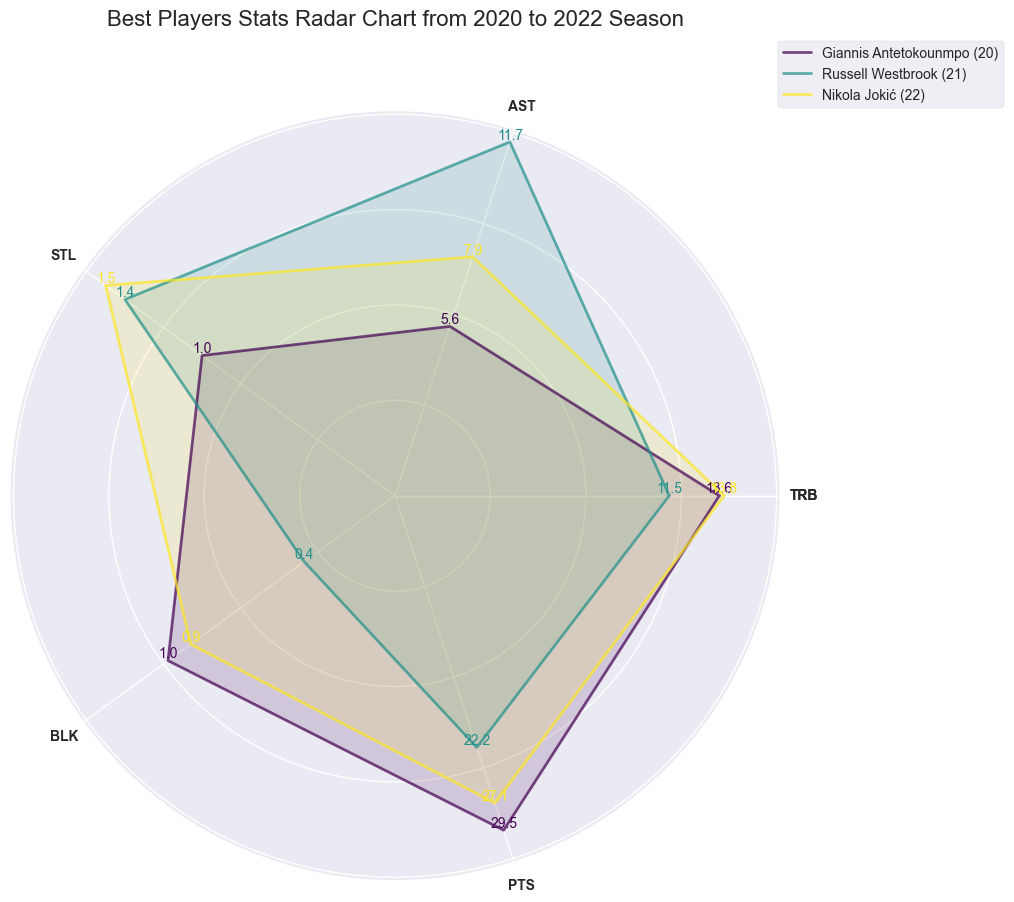

In [20]:

import seaborn as sns

def fancy_radar_chart(players_data, attributes, max_values):
    """Plots a fancier radar chart with multiple players' data."""
    # Number of attributes
    num_vars = len(attributes)

    # Set the maximum values for the plot
    max_val_dict = dict(zip(attributes, max_values))

    # Calculate the angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    # Plotting the radar chart with a custom style
    with plt.style.context('seaborn-v0_8-notebook'):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

        # Set a sophisticated color palette
        colors = plt.cm.viridis(np.linspace(0, 1, len(players_data)))

        for i, (_, row) in enumerate(players_data.iterrows()):
            values = [row[attr] / max_val_dict[attr] for attr in attributes]  # Normalize each attribute based on its max value
            values += values[:1]  # Close the circle
            ax.plot(angles, values, color=colors[i], label=f"{row['Player']} ({row['Season']})", linewidth=2, alpha=0.7)
            ax.fill(angles, values, color=colors[i], alpha=0.15)  # Add a slight fill
            # Add actual data values as text labels
            for j, value in enumerate(values[:-1]):
                if value > 0.1:  # Adjust this threshold as needed
                    ax.text(angles[j], value, f"{row[attributes[j]]:.1f}", color=colors[i], ha='center', va='bottom')

        # Add gridlines
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8], alpha=0.5)
        ax.set_yticklabels([])
        attributes += attributes[:1]  # Close the circle
        ax.set_xticks(angles)
        ax.set_xticklabels(attributes, fontweight='bold')
        ax.set_title('Best Players Stats Radar Chart from 2020 to 2022 Season', size=16, y=1.1)
        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Extracting best players from the last three seasons for the demonstration
filtered_best_players = best_players[best_players['Season'].isin(['20', '21', '22'])]

attributes = ["TRB", "AST", "STL", "BLK", "PTS"]
max_values = [20, 15, 2, 1.7, 40]  # These values can be adjusted based on the dataset's nature
fancy_radar_chart(filtered_best_players, attributes, max_values)
